# **Random Forest Stock Trend Classifier (v2)**
## **Project Overview**
This notebook implements a machine learning pipeline to predict short-term stock market direction. Unlike traditional technical analysis which relies on subjective chart patterns, this project uses a Random Forest Classifier trained on statistically stationary features.
## **Key Objectives**
1. **Solve Non-Stationarity:** Financial data distributions change over time. We transform raw prices into ratios, oscillators, and distances to allow the model to generalize across different market regimes.
2. **Dynamic Labeling:** Fixed thresholds (e.g., +2% gain) fail during high volatility. We implement a Volatility-Adaptive Target using the Average True Range (ATR).
3. **Robust Validation:** We utilize Walk-Forward Validation (TimeSeriesSplit) to simulate real-world trading and prevent look-ahead bias.

### **Imports**

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os

# Financial Data Source
import yfinance as yf

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create directory for saving plots (for README)
os.makedirs('images', exist_ok=True)

### **Configuration**

In [4]:
# Global variables for easy adjustment of the model's scope.
TICKER = "NVDA"
START_DATE = "2015-12-01"
END_DATE = "2025-12-05"
PREDICTION_DAYS = 3 # Forecast horizon (Trading Days)

### **Data Extraction (ETL)**
We pull historical OHLCV (Open, High, Low, Close, Volume) data from Yahoo Finance. This function handles API errors and cleans the multi-index formatting often returned by yfinance.

In [5]:
def get_data(ticker, start=None, end=None, period=None):
    """
    Fetches historical stock data from Yahoo Finance.
    
    Arguments:
        ticker (str): Symbol (e.g., 'AAPL')
        start (str): Start date 'YYYY-MM-DD'
        end (str): End date 'YYYY-MM-DD'
        period (str): Optional relative period (e.g., '6mo') for live prediction
        
    Returns:
        pd.DataFrame: Cleaned OHLCV data
    """
    print(f"Downloading data for {ticker}...")
    try:
        if period:
            df = yf.download(ticker, period=period, progress=False, auto_adjust=True)
        else:
            df = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()

    # Data Cleaning: Fix yfinance MultiIndex columns (e.g., ('Close', 'AAPL') -> 'Close')
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
        
    # Remove zero-volume days (market holidays/errors)
    df = df[df['Volume'] > 0].copy()
    return df

### **Feature Engineering**
Calculation of technical indicators to capture different aspects of market behavior:
- **Volatility (ATR):** Measures the "temperature" of the market.
- **Trend Strength (ADX):** Filters out choppy/ranging markets.
- **Volume (VWAP/OBV):** Confirms if price moves are supported by institutional volume.
- **Momentum (RSI/MACD):** Identifies overbought/oversold conditions.

*Note: All features are normalized (e.g., divided by price) to ensure stationarity.*

In [6]:
def add_technical_indicators(df):
    """
    Calculates technical indicators and adds them as new columns.
    Includes logic to handle index alignment for vector operations.
    """
    df = df.copy()
    
    # 1. VOLATILITY: Average True Range (ATR)
    # ATR captures the volatility of the asset. We use it later for dynamic targeting.
    prev_close = df['Close'].shift(1)
    tr1 = df['High'] - df['Low']
    tr2 = (df['High'] - prev_close).abs()
    tr3 = (df['Low'] - prev_close).abs()
    
    # Maximum of the three ranges is the True Range
    df['TR'] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df['ATR'] = df['TR'].rolling(window=14).mean()
    
    # Normalized ATR (Percentage of price) is better for ML than raw dollar ATR
    df['ATR_Perc'] = df['ATR'] / df['Close']

    # 2. TREND STRENGTH: Average Directional Index (ADX)
    # ADX measures how strong a trend is, regardless of direction.
    plus_dm = df['High'].diff()
    minus_dm = df['Low'].diff()
    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0.0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm > 0), -minus_dm, 0.0)
    
    # Align indexes explicitly to prevent NaN propagation in pandas math
    plus_di = 100 * (pd.Series(plus_dm, index=df.index).ewm(alpha=1/14).mean() / df['ATR'])
    minus_di = 100 * (pd.Series(minus_dm, index=df.index).ewm(alpha=1/14).mean() / df['ATR'])
    
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    df['ADX'] = dx.ewm(alpha=1/14).mean()

    # 3. VOLUME: OBV & VWAP
    # OBV (On-Balance Volume): Accumulation vs Distribution
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    df['OBV_Slope'] = df['OBV'].diff(5) # 5-day slope reveals volume momentum
    
    # VWAP (Volume Weighted Average Price) - 20 Day Rolling
    v_price = df['Close'] * df['Volume']
    df['VWAP_20'] = v_price.rolling(window=20).sum() / df['Volume'].rolling(window=20).sum()
    # Distance from VWAP shows if price is extended
    df['Dist_VWAP'] = (df['Close'] - df['VWAP_20']) / df['VWAP_20']

    # 4. SUPPORT/RESISTANCE: Donchian Channels
    # Rolling High/Low over 20 days
    df['High_20'] = df['High'].rolling(window=20).max()
    df['Low_20'] = df['Low'].rolling(window=20).min()
    
    # Interaction Features: How close is price to the 20-day breakout?
    df['Dist_High_20'] = (df['High_20'] - df['Close']) / df['Close']
    df['Dist_Low_20'] = (df['Close'] - df['Low_20']) / df['Close']

    # 5. MOMENTUM: RSI & MACD
    # Relative Strength Index (RSI)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).ewm(span=14, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(span=14, adjust=False).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # SMA Distance (Mean Reversion)
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['Dist_SMA_50'] = (df['Close'] - df['SMA_50']) / df['SMA_50']
    
    # Normalized MACD
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['Norm_MACD'] = df['MACD'] / df['Close']

    # 6. PRICE ACTION: Candlestick Stats
    # Body Percentage: Large body = conviction, Small body = indecision
    df['Body_Size'] = (df['Close'] - df['Open']).abs()
    df['Total_Range'] = df['High'] - df['Low']
    df['Body_Perc'] = df['Body_Size'] / df['Total_Range']

    return df

### **Execution: Load and Process**

In [7]:
df = get_data(TICKER, START_DATE, END_DATE)
print(f"Raw Data Shape: {df.shape}")

# Apply Feature Engineering
df = add_technical_indicators(df)

# Remove NaN rows created by rolling windows (e.g., SMA_50 needs 50 days of data)
df.dropna(inplace=True)
print(f"Data Shape after Feature Engineering: {df.shape}")

Raw Data Shape: (2518, 5)
Data Shape after Feature Engineering: (2469, 25)


### **Target Creation (Labeling)**
We use a Dynamic Volatility Threshold for labeling data. </br>
*Problem:* A 2% price move in 2017 is huge, but in 2020 it was just noise. Fixed percentages don't work. </br>
*Solution:* We use 1.0 * ATR as the threshold. If the price moves more than the average daily range over the next 5 days, it's a valid signal.

In [8]:
# Calculate Future Return
df['Future_Close'] = df['Close'].shift(-PREDICTION_DAYS)
df['Actual_Return'] = df['Future_Close'] - df['Close']

def label_data_dynamic(row):
    """
    Labels data based on dynamic ATR threshold.
    1 = BUY  (Return > 1.0 * ATR)
    -1 = SELL (Return < -1.0 * ATR)
    0 = HOLD (Return is within noise range)
    """
    volatility_barrier = row['ATR'] * 1.0
    
    if row['Actual_Return'] > volatility_barrier:
        return 1
    elif row['Actual_Return'] < -volatility_barrier:
        return -1
    else:
        return 0

df['Target'] = df.apply(label_data_dynamic, axis=1)

# Drop the last few rows where Future_Close is NaN
df.dropna(inplace=True)

print("Class Distribution:\n", df['Target'].value_counts())

Class Distribution:
 Target
 0    1445
 1     614
-1     407
Name: count, dtype: int64


### **Model Training (Walk-Forward Validation)**
We use TimeSeriesSplit instead of random shuffling. Random shuffling introduces look-ahead bias in financial data (the model "sees" the future). Walk-forward validation respects the temporal order of data.

In [9]:
# Define Features (X) and Target (y)
# Note: We only use the stationary features we created, not the raw prices.
features = [
    'RSI', 'ADX', 'ATR_Perc',        # Momentum & Volatility
    'Dist_VWAP', 'Dist_SMA_50',      # Trend Deviations
    'Norm_MACD', 'OBV_Slope',        # Oscillators
    'Dist_High_20', 'Dist_Low_20',   # Support/Resistance
    'Body_Perc'                      # Price Action
]

X = df[features]
y = df['Target']

# Initialize Random Forest with class_weight='balanced' to handle any imbalance
model = RandomForestClassifier(n_estimators=200, min_samples_split=10, 
                               max_depth=10, class_weight='balanced', 
                               random_state=42)

# Walk-Forward Validation
tscv = TimeSeriesSplit(n_splits=5)
print("Performing Walk-Forward Validation...")

scores = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    scores.append(acc)
    print(f"Fold Accuracy: {acc:.4f}")

print(f"\nAverage Walk-Forward Accuracy: {np.mean(scores):.4f}")

# Final Training on the most recent 85% of data (leaving 15% for final test)
split = int(len(X) * 0.85)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

model.fit(X_train, y_train)
print("Final Model Trained.")

Performing Walk-Forward Validation...
Fold Accuracy: 0.4720
Fold Accuracy: 0.5377
Fold Accuracy: 0.4939
Fold Accuracy: 0.4428
Fold Accuracy: 0.3869

Average Walk-Forward Accuracy: 0.4667
Final Model Trained.


### **Model Evaluation and Visualization**
We evaluate the model using:
- **Classification Report:** Precision/Recall for Buy/Sell signals.
- **Feature Importance:** Which indicators matter most?
- **Confusion Matrix:** Where is the model making mistakes?


Classification Report (Test Data):
              precision    recall  f1-score   support

          -1       0.15      0.20      0.17        66
           0       0.57      0.48      0.52       220
           1       0.16      0.19      0.18        84

    accuracy                           0.36       370
   macro avg       0.29      0.29      0.29       370
weighted avg       0.40      0.36      0.38       370

Saved feature_importance.png


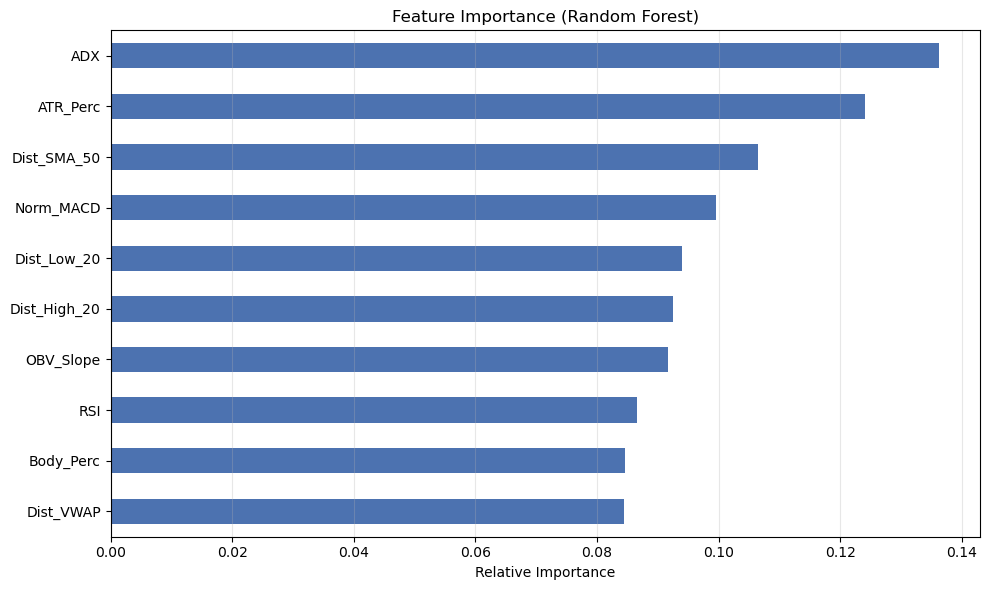

Saved confusion_matrix.png


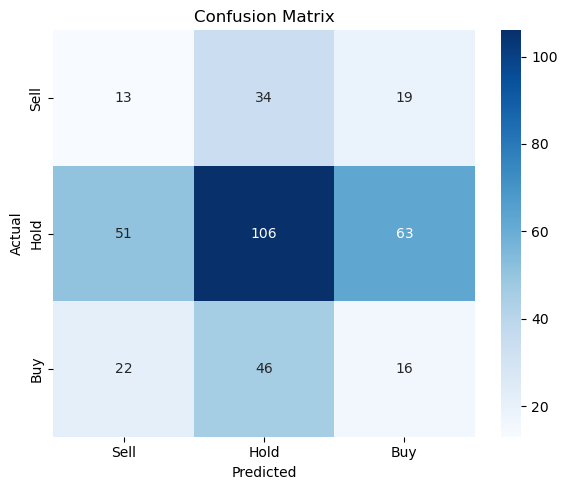

In [10]:
y_pred = model.predict(X_test)

print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_pred))

# 1. Feature Importance Plot
plt.figure(figsize=(10, 6))
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', color='#4c72b0')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Relative Importance")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('images/feature_importance.png', dpi=300) # Save for README
print("Saved feature_importance.png")
plt.show()

# 2. Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sell', 'Hold', 'Buy'], yticklabels=['Sell', 'Hold', 'Buy'])
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('images/confusion_matrix.png', dpi=300) # Save for README
print("Saved confusion_matrix.png")
plt.show()

### **Live Predictor Function**
This function fetches the very latest market data, applies the same feature engineering pipeline, and outputs a prediction. This is used for Paper Trading validation.

In [11]:
def predict_live(ticker, model):
    print(f"\n--- Live Analysis for {ticker} ---")
    
    # Download 6 months to ensure rolling windows (like SMA50) are full
    data = get_data(ticker, period="6mo")
    
    # Apply same feature engineering
    data = add_technical_indicators(data)
    
    # Grab the specific feature columns for the latest day
    latest_features = data.iloc[[-1]][features]
    
    # Predict
    prediction = model.predict(latest_features)[0]
    probs = model.predict_proba(latest_features)[0]
    
    # Mapping
    label_map = {1: "BUY", -1: "SELL", 0: "HOLD"}
    
    # Context Stats
    current_price = data.iloc[-1]['Close']
    current_atr = data.iloc[-1]['ATR']
    current_adx = data.iloc[-1]['ADX']
    current_rsi = data.iloc[-1]['RSI']
    
    print(f"Current Price: ${current_price:.2f}")
    print(f"Current Volatility (ATR): {current_atr:.2f}")
    print(f"Trend Strength (ADX): {current_adx:.2f} (>25 is trending)")
    print(f"Momentum (RSI): {current_rsi:.2f}")
    print(f"\nModel Prediction: {label_map[prediction]}")
    print(f"Confidence: Sell {probs[0]:.2f} | Hold {probs[1]:.2f} | Buy {probs[2]:.2f}")

In [13]:
# Execute Live Prediction
predict_live(TICKER, model)


--- Live Analysis for NVDA ---
Current Price: $175.02
Current Volatility (ATR): 5.72
Trend Strength (ADX): -276.34 (>25 is trending)
Momentum (RSI): 32.32

Model Prediction: BUY
Confidence: Sell 0.21 | Hold 0.38 | Buy 0.41
